# CHAPTER 03. 평가

- 분류의 성능 평가 지표
  - 정확도(Accuracy)
  - 오차행렬(Confusion Matrix)
  - 정밀도(Precision)
  - 재현율(Recall)
  - F1 스코어
  - ROC AUC

# 01. 정확도(Accuracy)
예측 결과가 동일한 데이터 개수 / 전체 예측 데이터 건수

In [2]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit( ) 메서드는 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    # predict( ) 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
    def predict(self, X):
        pred = np.zeros((X.shape[0],1))
        for i in range (X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [18]:
# 2장에서 만든 함수

from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df.fillna({'Age': titanic_df['Age'].mean(),
                       'Cabin': 'N',  
                       'Embarked': 'N',
                       'Fare': 0}, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier을 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


- 단순히 Sex 피처가 1이면 0, 아니면 1로 예측하는 매우 단순한 Classifier
- 단순한 알고리즘으로 예측을 하더라도 데이터 구성에 따라 정확도 높게 나옴
- 특히 정확도는 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님

- MINIST 데이터 세트를 변환해 불균형한 데이터 세트로 만든 뒤 정확도 지표 적용 시 어떤 문제가 발생할 수 있는지 살펴보기

In [28]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as mp
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
        
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self,X):
        return np.zeros( (len(X),1), dtype=bool )

# 사이킷런의 내장 데이터 세트인 load_digits( )를 이용해 MINIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [30]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts() )

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
Name: count, dtype: int64


In [34]:
# DummyClassifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

모든 예측을 0으로 하여도 정확도는:0.900


- 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안 됨

# 02. 오차 행렬(confusion matrix, 혼동행렬)

- 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표  


|                      |                      | 예측 클래스 (Predicted Class)|                      |
|----------------------|----------------------|----------------------|----------------------|
|                      |                      | Negative (0)         | Positive (1)         |
| **실제 클래스 (Actual Class)**| Negative (0)         | TN (True Negative)  | FP (False Positive)  |
|                      | Positive (1)         | FN (False Negative) | TP (True Positive)   |


In [53]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

$$ 정확도 = \frac{TN + TP}{TN + FP +FN +TP}$$

# 03. 정밀도와 재현율

- 정밀도
$$ 정밀도 = \frac{TP}{FP+TP} $$
  - 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
  - 양성 예측도

- 재현율
$$ 재현율 = \frac{TP}{FN+TP} $$
  - 실제값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
  - 민감도(Sensitivity), TPR(True Positive Rate)

- 재현율이 상대적으로 더 중요한 지표인 경우: 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
- 정밀도가 상대적으로 더 중요한 지표인 경우: 실제 Negative 음성인 데이터 예측을 Positive로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
- 서로 보완적인 지표로 분류의 성능을 평가하는 데 적용됨

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy,precision,recall))

In [87]:
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.2, random_state=11)
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


- LogisticRegression 객체의 생성 인자로 입력되는 solver='liblinear'는 로지스틱 회귀의 최적화 알고리즘 유형을 지정하는 것.  
- solver의 기본값은 lbfgs이며 데이터 세트가 상대적으로 크고 다중 분류인 경우 적합함.

## 정밀도/재현율 트레이드오프(Trade-off)

- 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한 쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움
- predict_proba( ) : 개별 데이터별로 예측 확률을 반환
  - 개별 클래스의 예측 확률을 ndarray m x n (m:입력값의 레코드 수, n: 클래스 값 유형) 형태로 반환
  - 입력 테스트 데이터 세트의 표본 개수가 100개이고 예측 클래스 값 유형이 2개(이진 분류)라면 반환값은 100 x 2 ndarray임
  - 각 열은 개별 클래스의 예측 확률. 이진 분류에서 첫 번째 칼럼은 0 Negative의 확률, 두 번째 칼럼은 1 Positive의 확률

In [91]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출\n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba() 결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출
: [[0.44935227 0.55064773]
 [0.86335512 0.13664488]
 [0.86429645 0.13570355]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.44935227 0.55064773 1.        ]
 [0.86335512 0.13664488 0.        ]
 [0.86429645 0.13570355 0.        ]]


In [93]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
     [2,0,0],
     [0,1.1,1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [95]:
# Binarizer의 threshold 설정값. 분류 결정 임계값임.
custom_threshold = 0.5

# predict_proba( ) 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer을 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


In [97]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197


- 임곗값을 낮추니 재현율 값이 올라가고 정밀도가 떨어짐
- 확률이 0.5가 아닌 0.4부터 Positive로 예측을 하기 때문에 임곗값을 낮출수록 True값이 많아짐

In [290]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.5, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4


InvalidParameterError: The 'y_score' parameter of roc_auc_score must be an array-like. Got None instead.

precision_recall_curve( )
- 입력 파라미터:
  - y_true: 실제 클래스값 배열(배열 크기=[데이터 건수])
  - probas_pred: Positive 칼럼의 예측 확률 배열(배열 크기=[데이터 건수])

- 반환 값:
  - 정밀도: 임곗값별 정밀도 값을 배열로 반환
  - 재현율: 임곗값별 재현율 값을 배열로 반환

In [103]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 Shape:', thresholds.shape)

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값:', np.round(thresholds[thr_index], 2))

# 15step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 Shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임계값: [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도: [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율: [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


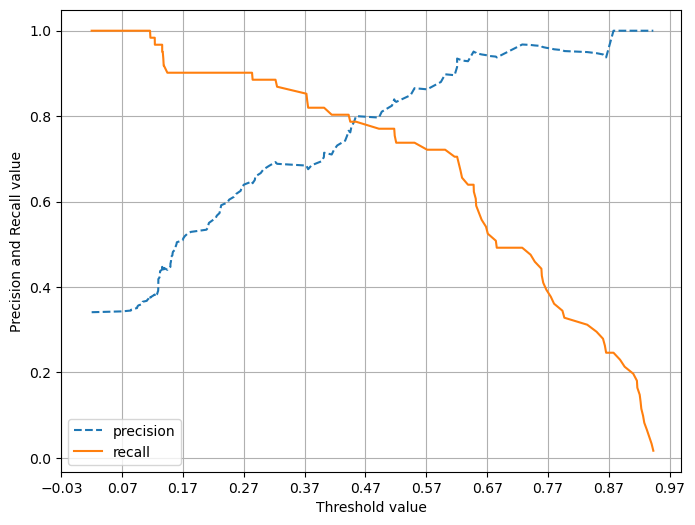

In [147]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    #X축을 thresholds, y축 정밀도, 재현율 값으로 각각 plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    #threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    #x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value');plt.ylabel('Precision and Recall value')
    plt.legend();plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

## 정밀도와 재현율의 맹점
### 정밀도가 100%가 되는 방법
- 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측
### 재현율이 100%가 되는 방법
- 모든 환자를 Positive로 예측

-> 정밀도와 재현율의 수치가 적절하게 조합돼 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요함

# 04. F1 스코어
- 정밀도와 재현율을 결합한 지표
- 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐

$$ F1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} $$


In [159]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7966


In [242]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1)) 

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[80 20]
 [17 37]]
정확도: 0.7597, 정밀도: 0.6491, 재현율: 0.6852, F1: 0.6667
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, F1: 0.6857
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804
임곗값: 0.55
오차 행렬
[[91  9]
 [23 31]]
정확도: 0.7922, 정밀도: 0.7750, 재현율: 0.5741, F1: 0.6596
임곗값: 0.6
오차 행렬
[[91  9]
 [26 28]]
정확도: 0.7727, 정밀도: 0.7568, 재현율: 0.5185, F1: 0.6154


- F1 스코어는 임계값이 0.6일 때 가장 좋은 값. 그러나 재현율이 크게 감소하고 있음

# 05. ROC 곡선과 AUC

- ROC 곡선: FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)가 어떻게 변하는지 나타내는 곡선
- 민감도(재현율, TPR(True Positive Rate)): 실제값 Positive가 정확히 예측돼야 하는 수준
- 특이성(Specificity, TNR(True Negative Rate)): 실제값 Negative가 정확히 예측돼야 하는 수준

$$ FPR = \frac{\text{FP}}{\text{FP+TN}} = 1-TNR = 1-특이성 $$

- ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화값을 구함 - 분류 결정 임계값을 변경
- FPR을 0으로 만드려면 임계값을 1로 지정
- FPR을 1로 만드려면 임계값을 0으로 지정
- roc_curve( )
  - 입력 파라미터:
    - y_true: 실제 클래스 값 array (array shape = [데이터 건수])
    - y_score: predict_proba()의 반환 값 array에서 Positive 칼럼의 예측 확률이 보통 사용됨. array, shape = [n_samples]
  - 반환 값:
    - fpr: fpr 값을 array로 반환
    - tpr: tpr 값을 array로 반환
    - thresholds: threshold 값 array

In [173]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임계값 배열에서 샘플로 데이터를 추출하되, 임계값을 5 step로 추출
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작.
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index:', thr_index)
print('샘플 index로 추출한 임계값:', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임계값: [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임계값별 FPR: [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임계값별 TPR: [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


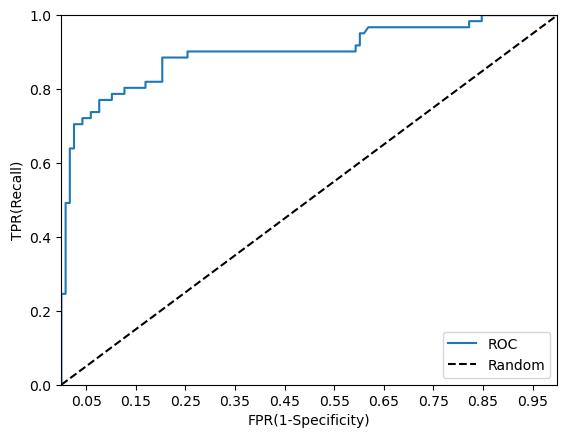

In [179]:
def roc_curve_plot(y_test, pred_proba_c1):
    #임계값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],'k--',label='Random')
    
    # FPR X축의 Scale을 0.1 단위로 변경, X,Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-Specificity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()

roc_curve_plot(y_test, pred_proba[:,1])

- 분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC 값(Area Under Curve)

In [188]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8987


In [252]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc)) 

# 06. 피마 인디언 당뇨병 예측

구성 피처
- Pregnancies
- Glucose
- BloodPressure
- SkinThickness
- Insulin
- BMI
- DiabetesPedigreeFunction
- Age
- Outcome: 클래스 결정 값(0 또는 1)

In [194]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [196]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [212]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

In [266]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[88 12]
 [22 32]]
정확도: 0.7792, 정밀도: 0.7273, 재현율: 0.5926, F1: 0.7966, AUC: 0.8437


- 재현율 성능에 초점 맞추기
- 정밀도 재현율 곡선을 보고 임계값별 정밀도와 재현율 값의 변화 확인하기

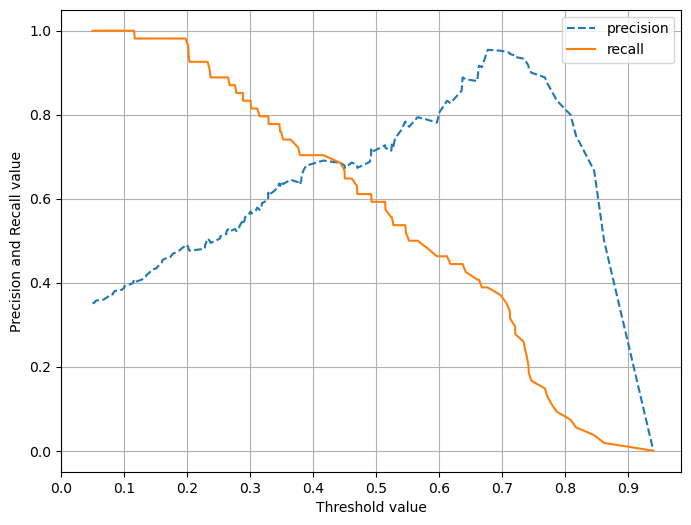

In [269]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

- 임계값을 0.42 정도로 낯추면 정밀도와 재현율이 균형을 맞추지만, 둘 다 0.7이 안되는 수치
- 데이터 값 점검하기

In [272]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- min() 값이 0인 피처가 상당히 많음

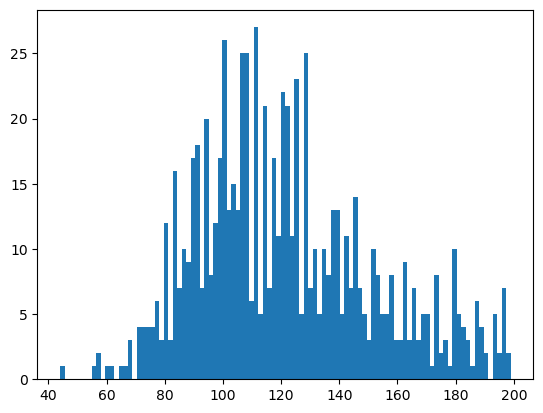

In [275]:
plt.hist(diabetes_data['Glucose'], bins=100)
plt.show()

In [277]:
# 0값을 검사할 피처명 리스트
zero_features = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 데이터 건수 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{0} 0  건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0  건수는 0, 퍼센트는 0.00 %
BloodPressure 0  건수는 0, 퍼센트는 0.00 %
SkinThickness 0  건수는 0, 퍼센트는 0.00 %
Insulin 0  건수는 0, 퍼센트는 0.00 %
BMI 0  건수는 0, 퍼센트는 0.00 %


In [279]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

In [281]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.7966, AUC: 0.8433


In [283]:

thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.5]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)


임곗값: 0.3


InvalidParameterError: The 'y_score' parameter of roc_auc_score must be an array-like. Got None instead.

- 0.48이 좋은 임계값으로 보임
- 임계값을 0.48로 낮춘 상태에서 다시 예측

In [288]:
# 임계값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.7966, AUC: 0.8433
